## Binary classification with Logistic regression 

### import libraries 

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import getpass

### connection to sql 

In [75]:
mysqlpassword = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + mysqlpassword + '@localhost/bank'
engine = create_engine(connection_string)

In [76]:
df=pd.read_sql_query('''
select l.loan_id, l.status, count(distinct t.trans_id) as nooftrans,
datediff(19981231, convert(a.date, date)) as ageofaccount, 
d.A12 as 95unemp, d.A13 as 96unemp, dp.type,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid,
t.k_symbol as trans_type
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where status in ('A', 'B') and dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, datediff(19981231, convert(a.date, date)),
 dp.type, round((l.amount-l.payments)/l.amount,2), t.k_symbol
''', engine)


### EDA - exploratory data analysis - get to know the data 

In [77]:
df.head(20)


,loan_id,status,nooftrans,ageofaccount,95unemp,96unemp,type,loanamount,birth_number,crime95,crime96,ratiopaid,trans_type
0,4959,A,191,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,
1,4959,A,32,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,SIPO
2,4959,A,65,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,SLUZBY
3,4959,A,70,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,UROK
4,4959,A,16,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,UVER
5,4961,B,89,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,
6,4961,B,8,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SANKC. UROK
7,4961,B,26,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SIPO
8,4961,B,40,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SLUZBY
9,4961,B,90,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,UROK


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loan_id       1176 non-null   int64  
 1   status        1176 non-null   object 
 2   nooftrans     1176 non-null   int64  
 3   ageofaccount  1176 non-null   int64  
 4   95unemp       1176 non-null   float64
 5   96unemp       1176 non-null   float64
 6   type          1176 non-null   object 
 7   loanamount    1176 non-null   int64  
 8   birth_number  1176 non-null   int64  
 9   crime95       1176 non-null   int64  
 10  crime96       1176 non-null   int64  
 11  ratiopaid     1176 non-null   float64
 12  trans_type    1176 non-null   object 
dtypes: float64(3), int64(7), object(3)
memory usage: 119.6+ KB


In [79]:
df.describe()

,loan_id,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,6222.014456,63.234694,1627.754252,2.889303,3.528810,97831.673469,579574.846939,17456.405612,19626.505102,0.945434
std,681.238121,62.757156,454.954941,1.976881,2.253072,72452.831310,128884.455307,29865.631169,34698.832743,0.023177
min,4959.000000,1.000000,550.000000,0.000000,0.430000,4980.000000,350721.000000,0.000000,888.000000,0.920000
25%,5657.000000,21.000000,1222.000000,1.390000,1.960000,44628.000000,465119.000000,2157.000000,2222.500000,0.920000
50%,6266.000000,43.000000,1837.000000,2.800000,3.600000,79824.000000,581007.000000,3804.000000,3894.000000,0.960000
75%,6753.000000,68.000000,2029.000000,4.090000,4.790000,127080.000000,685907.000000,9878.000000,10108.000000,0.960000
max,7308.000000,330.000000,2178.000000,7.340000,9.400000,464520.000000,805709.000000,85677.000000,99107.000000,0.980000


In [80]:
df.birth_number.unique()

array([450204, 395423, 620209, 445613, 420128, 455703, 391130, 670924,
       400827, 471008, 421210, 405212, 565913, 510806, 556119, 610930,
       480521, 775510, 455612, 636231, 686220, 466017, 411111, 570429,
       755912, 575122, 405724, 475722, 680722, 405420, 570919, 635125,
       765609, 391206, 406204, 766012, 745620, 430104, 655716, 666210,
       400326, 706007, 790214, 805709, 565425, 400907, 581007, 626228,
       506020, 670210, 395315, 720206, 655604, 361223, 571101, 521128,
       641016, 525726, 351225, 515625, 456227, 540309, 575628, 635204,
       760916, 495624, 406101, 680506, 595810, 455908, 490724, 466007,
       515407, 565313, 675529, 610502, 715920, 350721, 726227, 640313,
       735515, 705912, 596122, 680909, 520717, 795406, 351003, 510410,
       631012, 805430, 536225, 406015, 561230, 495308, 575127, 721203,
       700428, 485812, 786121, 530618, 431126, 620523, 790326, 636224,
       680129, 570929, 640513, 620911, 575906, 705210, 406202, 380916,
      

In [81]:
df['status'].value_counts()

A    1001
B     175
Name: status, dtype: int64

In [82]:
df['trans_type'].value_counts()

UROK           234
UVER           234
SLUZBY         234
               220
SIPO           162
POJISTNE        44
SANKC. UROK     34
                14
Name: trans_type, dtype: int64

### histograms or boxplots



<AxesSubplot:xlabel='nooftrans', ylabel='Count'>

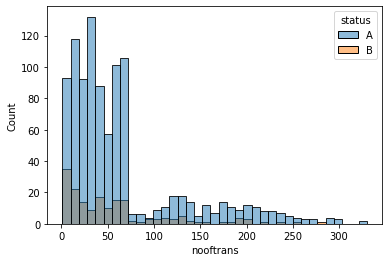

In [83]:
sns.histplot(df, x='nooftrans', hue='status')

<AxesSubplot:xlabel='trans_type', ylabel='Count'>

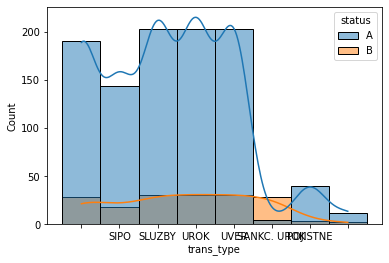

In [84]:
sns.histplot(df, x='trans_type', hue='status', kde=True)

<AxesSubplot:xlabel='loanamount', ylabel='status'>

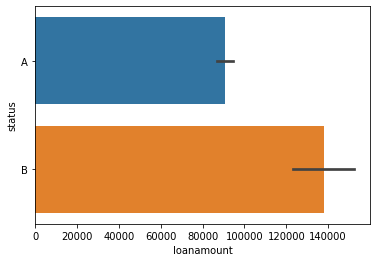

In [85]:
sns.barplot(x='loanamount', y='status', data=df)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ageofaccount', ylabel='Density'>

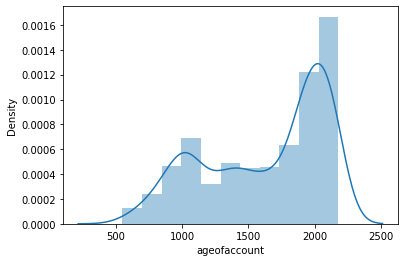

In [86]:
sns.distplot(df['ageofaccount'])

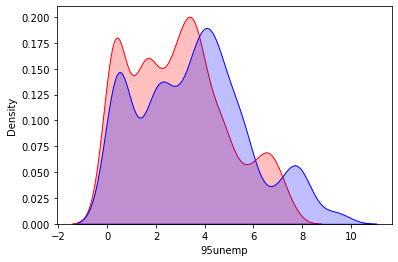

In [87]:
fig = sns.kdeplot(df['95unemp'], shade=True, color="r")
fig = sns.kdeplot(df['96unemp'], shade=True, color="b")
plt.show()

### Check for multicollinearity 

In [88]:

correlation = df.corr()
correlation


,loan_id,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
loan_id,1.000000,0.052208,0.089506,-0.076079,-0.071482,0.082496,0.152636,0.149199,0.148527,0.128093
nooftrans,0.052208,1.000000,0.302635,-0.045499,-0.050287,0.068390,0.024139,0.020367,0.020573,0.117392
ageofaccount,0.089506,0.302635,1.000000,-0.159959,-0.188347,0.281791,0.057378,0.074959,0.075862,0.427720
95unemp,-0.076079,-0.045499,-0.159959,1.000000,0.960740,-0.004813,0.076052,-0.542406,-0.547736,-0.043876
96unemp,-0.071482,-0.050287,-0.188347,0.960740,1.000000,-0.002525,0.065575,-0.573541,-0.577577,-0.043536
loanamount,0.082496,0.068390,0.281791,-0.004813,-0.002525,1.000000,0.003621,-0.003788,-0.002314,0.592571
birth_number,0.152636,0.024139,0.057378,0.076052,0.065575,0.003621,1.000000,-0.027943,-0.027854,0.035589
crime95,0.149199,0.020367,0.074959,-0.542406,-0.573541,-0.003788,-0.027943,1.000000,0.999733,0.020459
crime96,0.148527,0.020573,0.075862,-0.547736,-0.577577,-0.002314,-0.027854,0.999733,1.000000,0.021961
ratiopaid,0.128093,0.117392,0.427720,-0.043876,-0.043536,0.592571,0.035589,0.020459,0.021961,1.000000


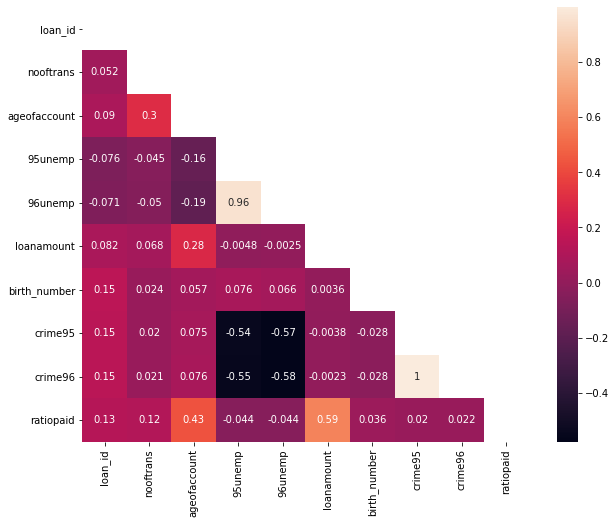

In [89]:

corr_matrix = df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True )


### Clean and wrangling steps 

In [90]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
#bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 
# feature engineering - take the columns and make more useful 

# split the data into num and cat --- > diff options cleaning / scaling

In [94]:
df.drop(['loan_id', 'type'], axis=1, inplace=True) 

In [95]:
df['crime_sum'] = df['crime95'] + df['crime96']

In [96]:
df.drop(['crime95', 'crime96'], axis=1, inplace=True)

In [116]:
df.drop(['crime_sum'], axis=1, inplace=True)

In [117]:
df.head()

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type
0,A,191,2134,0.29,0.43,80952,450204,0.96,1.0
1,A,32,2134,0.29,0.43,80952,450204,0.96,1.0
2,A,65,2134,0.29,0.43,80952,450204,0.96,1.0
3,A,70,2134,0.29,0.43,80952,450204,0.96,1.0
4,A,16,2134,0.29,0.43,80952,450204,0.96,1.0


### Pre processing 

In [118]:
# label / encode categorical columns 
# scale numerical columns 

In [119]:
from sklearn.preprocessing import OrdinalEncoder
# encoding trans type to numeric
ord_enc = OrdinalEncoder()
df["trans_type"] = ord_enc.fit_transform(df[["trans_type"]])
df.head(20)

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type
0,A,191,2134,0.29,0.43,80952,450204,0.96,1.0
1,A,32,2134,0.29,0.43,80952,450204,0.96,1.0
2,A,65,2134,0.29,0.43,80952,450204,0.96,1.0
3,A,70,2134,0.29,0.43,80952,450204,0.96,1.0
4,A,16,2134,0.29,0.43,80952,450204,0.96,1.0
5,B,89,1364,1.51,2.07,30276,395423,0.92,1.0
6,B,8,1364,1.51,2.07,30276,395423,0.92,0.0
7,B,26,1364,1.51,2.07,30276,395423,0.92,1.0
8,B,40,1364,1.51,2.07,30276,395423,0.92,1.0
9,B,90,1364,1.51,2.07,30276,395423,0.92,1.0


In [120]:
df['trans_type'].value_counts()

1.0    1142
0.0      34
Name: trans_type, dtype: int64

In [121]:
#cat
cat = df.select_dtypes(include=object)
cat.head()

,status
0,A
1,A
2,A
3,A
4,A


In [122]:
categorical = pd.get_dummies(cat, columns=['status'], drop_first=True)
categorical.head()

,status_B
0,0
1,0
2,0
3,0
4,0


In [123]:
# numerical scaling
from sklearn.preprocessing import Normalizer

In [124]:
X = df.select_dtypes(include=np.number)
X.head()

,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type
0,191,2134,0.29,0.43,80952,450204,0.96,1.0
1,32,2134,0.29,0.43,80952,450204,0.96,1.0
2,65,2134,0.29,0.43,80952,450204,0.96,1.0
3,70,2134,0.29,0.43,80952,450204,0.96,1.0
4,16,2134,0.29,0.43,80952,450204,0.96,1.0


In [125]:
df.head()

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type
0,A,191,2134,0.29,0.43,80952,450204,0.96,1.0
1,A,32,2134,0.29,0.43,80952,450204,0.96,1.0
2,A,65,2134,0.29,0.43,80952,450204,0.96,1.0
3,A,70,2134,0.29,0.43,80952,450204,0.96,1.0
4,A,16,2134,0.29,0.43,80952,450204,0.96,1.0


In [126]:
scaler = Normalizer().fit(X)
scaled = scaler.transform(X) # scaling to gaussian distr
scaled_X = pd.DataFrame(scaled) # convert back to DF
scaled_X.head()


,0,1,2,3,4,5,6,7
0,0.000418,0.004665,6.339779e-07,9.400362e-07,0.176972,0.984205,0.000002,0.000002
1,0.000070,0.004665,6.339780e-07,9.400363e-07,0.176972,0.984205,0.000002,0.000002
2,0.000142,0.004665,6.339780e-07,9.400363e-07,0.176972,0.984205,0.000002,0.000002
3,0.000153,0.004665,6.339780e-07,9.400363e-07,0.176972,0.984205,0.000002,0.000002
4,0.000035,0.004665,6.339780e-07,9.400363e-07,0.176972,0.984205,0.000002,0.000002


In [127]:
# if there are more categorical values, we have to concat back to the DF
# scaled_X = pd.concat([scaled_X, categorical['trans_type']], axis=1)

### split off the dependant variable (label)

In [128]:
# Y is a dependent variable (status)
y = categorical['status_B']
X = scaled_X

### train test split, get LOG REG model

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=40) #def train and test sets

## apply model and train model 

In [131]:
classification = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train) # training

### evaluate accuracy and test 

In [132]:
probabilities = classification.predict_proba(X_test)
preds = probabilities[:,1] # part of the array of predictions
import sklearn.metrics as metrics
fpr, tpr, treshold = metrics.roc_curve(y_test, preds) #fpr=FalsePositiveRate, tpr=TruePositiveRate, auc=AreaUnderTheCurve 
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.643938872444414

#### next steps

+ Visualise the accuracy of the predictions in some ways 

+ also think about - is there something I could do to improve my model accuracy?? 

### visualising accuracy - ROC / AUC 

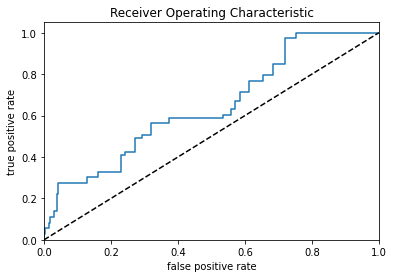

In [133]:
#roc curve plot 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC'%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()


### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [134]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

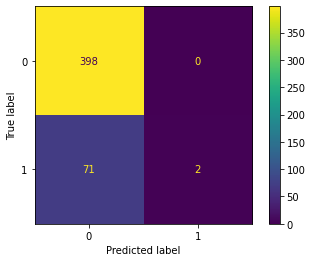

In [135]:
predictions = classification.predict(X_test)
accuracy_score(y_test, predictions)
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)

### data is highly imbalanced

this is affecting the accuracy of our predictions 
- what can be done to resolve that ?


+ option 1 - SMOTE 

+ option 2 - TOMEK LINKS 

